In [1]:
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
import joblib

In [2]:
og_df=pd.read_csv('../data/dress_rental_prices.csv')
df=og_df.copy()
df.drop(['Unnamed: 0','ID','Name'],axis=1,inplace=True)
df

,Brand,Colour,Catagories,Price
0,Stella McCartney,beige,dresses,111
1,Reformation,beige,dresses,50
2,Ghost,beige,dresses,75
3,Coucoo,beige,dresses,37
4,RIXO,beige,dresses,47
...,...,...,...,...
29992,Victoria Beckham,yellow,"dresses, Smart, midi, Short Sleeve, Pencil, Mo...",102
29993,Faithfull The Brand,yellow,"dresses, Floral, Polka Dot, Loose, Smart Casua...",43
29994,Solace London,yellow,"dresses, Vinyl-PVC-Synthetics, Smart, Formal, ...",75
29995,Rebecca Vallance,yellow,"dresses, Cotton-Jersey, Tie-Front, Skinny-Fit,...",42


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29997 entries, 0 to 29996
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Brand       29997 non-null  object
 1   Colour      29997 non-null  object
 2   Catagories  29883 non-null  object
 3   Price       29997 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 937.5+ KB


In [4]:

df.drop_duplicates(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22105 entries, 0 to 29996
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Brand       22105 non-null  object
 1   Colour      22105 non-null  object
 2   Catagories  21991 non-null  object
 3   Price       22105 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 863.5+ KB


In [6]:
brand_count=df['Brand'].value_counts()
brand_count.nunique

<bound method IndexOpsMixin.nunique of Brand
RIXO             1168
Self-Portrait     946
Ganni             728
Rat & Boa         660
Reformation       626
                 ... 
Cara Cara NYC       1
Rabbit              1
Steve Madden        1
BIMBA Y Lola        1
March11             1
Name: count, Length: 931, dtype: int64>

In [7]:
color_count=df['Colour'].value_counts().reset_index()
color_count

,Colour,count
0,black,3267
1,multi,2731
2,pink,2581
3,blue,2394
4,green,1952
5,white,1793
6,red,1627
7,beige,969
8,yellow,813
9,navy,672


<Axes: xlabel='Colour', ylabel='count'>

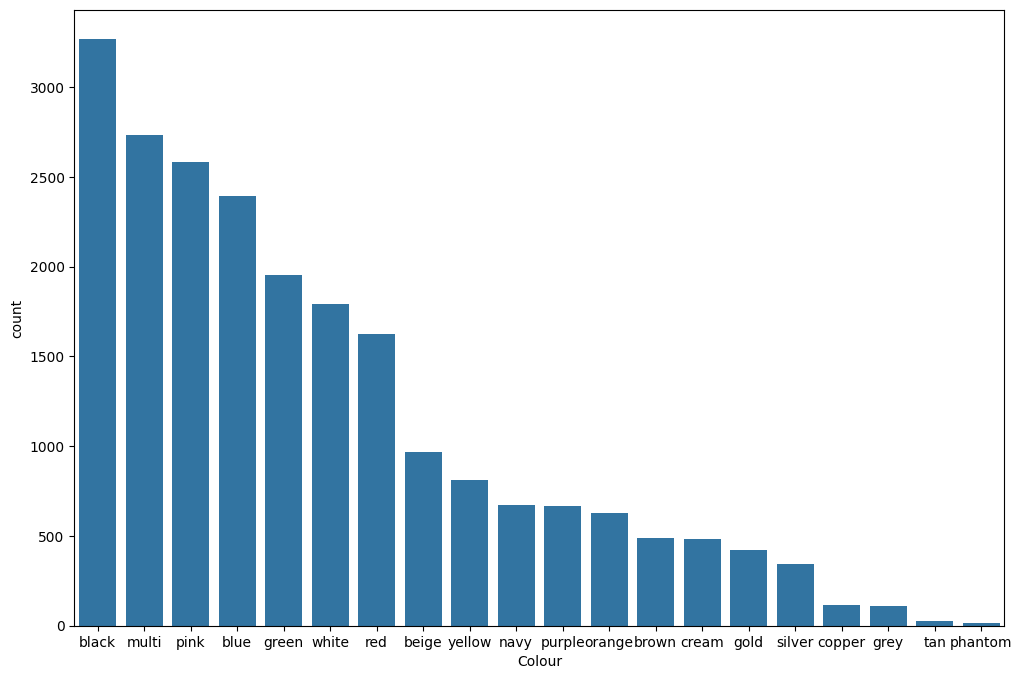

In [8]:
plt.figure(figsize=(12, 8))
sns.barplot(data=color_count,x='Colour',y='count')

In [9]:
df.head()

,Brand,Colour,Catagories,Price
0,Stella McCartney,beige,dresses,111
1,Reformation,beige,dresses,50
2,Ghost,beige,dresses,75
3,Coucoo,beige,dresses,37
4,RIXO,beige,dresses,47


<Axes: xlabel='Price', ylabel='Colour'>

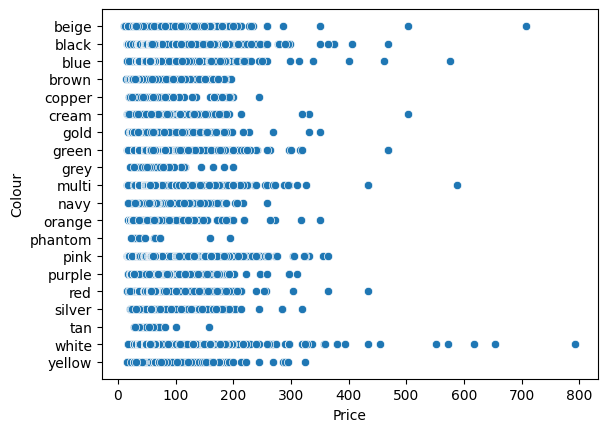

In [10]:
sns.scatterplot(data=df,x='Price',y='Colour')

In [11]:
filterd_df=df[df['Price'] < 350]
filterd_df

,Brand,Colour,Catagories,Price
0,Stella McCartney,beige,dresses,111
1,Reformation,beige,dresses,50
2,Ghost,beige,dresses,75
3,Coucoo,beige,dresses,37
4,RIXO,beige,dresses,47
...,...,...,...,...
29992,Victoria Beckham,yellow,"dresses, Smart, midi, Short Sleeve, Pencil, Mo...",102
29993,Faithfull The Brand,yellow,"dresses, Floral, Polka Dot, Loose, Smart Casua...",43
29994,Solace London,yellow,"dresses, Vinyl-PVC-Synthetics, Smart, Formal, ...",75
29995,Rebecca Vallance,yellow,"dresses, Cotton-Jersey, Tie-Front, Skinny-Fit,...",42


In [12]:
filterd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22069 entries, 0 to 29996
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Brand       22069 non-null  object
 1   Colour      22069 non-null  object
 2   Catagories  21955 non-null  object
 3   Price       22069 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 862.1+ KB


In [13]:
def prerprocess(X):
    num_col=X.select_dtypes(include=['int64']).columns
    cat_col=X.select_dtypes(include=['object']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor=ColumnTransformer(
        transformers=[
            ('num',numerical_transformer,num_col),
            ('cat',categorical_transformer,cat_col)
        ]
    )
    X_preprocessed = preprocessor.fit_transform(X)

    return X_preprocessed, preprocessor

In [14]:
def train_model(model, X_train,y_train):
    model.fit(X_train, y_train)
    return model

def evaluate_model(model,X_test,y_test):
    y_pred=model.predict(X_test)
    return r2_score(y_test, y_pred)



In [15]:
filterd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22069 entries, 0 to 29996
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Brand       22069 non-null  object
 1   Colour      22069 non-null  object
 2   Catagories  21955 non-null  object
 3   Price       22069 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 862.1+ KB


In [16]:
X=filterd_df.drop(['Price'],axis=1)
y=filterd_df['Price']


In [17]:
X_preprocessed, preprocessor = prerprocess(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [18]:
models=[
    RandomForestRegressor(),
    LinearRegression(),
    XGBRegressor()
]

In [19]:
for m in models:
    model=train_model( m,X_train, y_train)
    r2 = evaluate_model(model, X_test, y_test)
    print(f'Initial R² score of {m} : {r2}')    

Initial R² score of RandomForestRegressor() : 0.38976570764119256
Initial R² score of LinearRegression() : 0.44198268706862
Initial R² score of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 0.40368926525115967


In [20]:
def tune_xgb_hyperparameters(X_train, y_train):
    """
    Tune hyperparameters for XGBRegressor using GridSearchCV.
    
    Args:
    X_train (np.ndarray): The training features.
    y_train (pd.Series): The target variable for training.
    
    Returns:
    XGBRegressor: The best model found by GridSearchCV.
    """
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7,10,15,20],
        'learning_rate': [0.01, 0.1, 0.2,0.3],
        'subsample': [0.8, 1.0]
    }
    
    xgb_model = XGBRegressor(objective='reg:squarederror')
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [21]:
model=XGBRegressor().fit(X_train,y_train)

In [22]:
best_xgb_model = tune_xgb_hyperparameters(X_train, y_train)
xgb_r2_tuned = evaluate_model(best_xgb_model, X_test, y_test)
print(f'Tuned XGBoost R² score: {xgb_r2_tuned}')
    

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.

In [23]:
joblib.dump(best_xgb_model,'../models/XGB.joblib')

['../models/XGB.joblib']